In [1]:
import cv2

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [28]:
video_path = r'AI数据样本\瓷碗出粮（3种粮）+碗内余粮+积粮\1715675377828.mp4'
capture = cv2.VideoCapture(video_path)

count = 0
frame1, frame2 = None, None
while True:
    ret, frame = capture.read()
    count += 1
    if not ret:
        break
    if count == 100:
        frame1 = frame
    if count == 3000:
        frame2 = frame
    elif count >= 5000:
        break
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
capture.release()

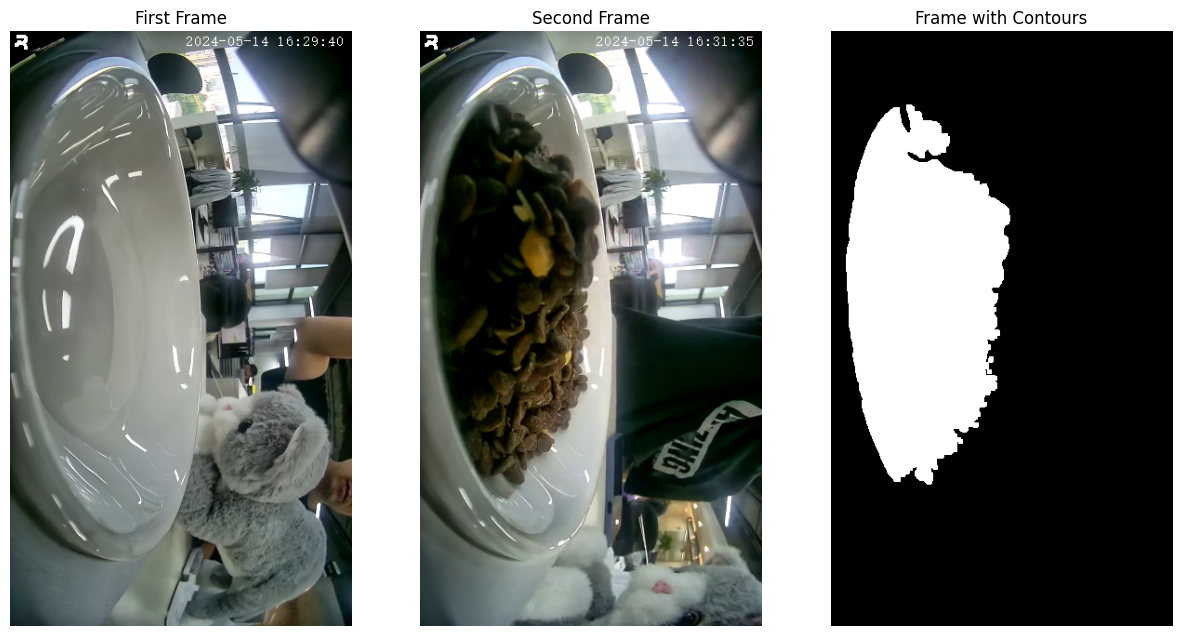

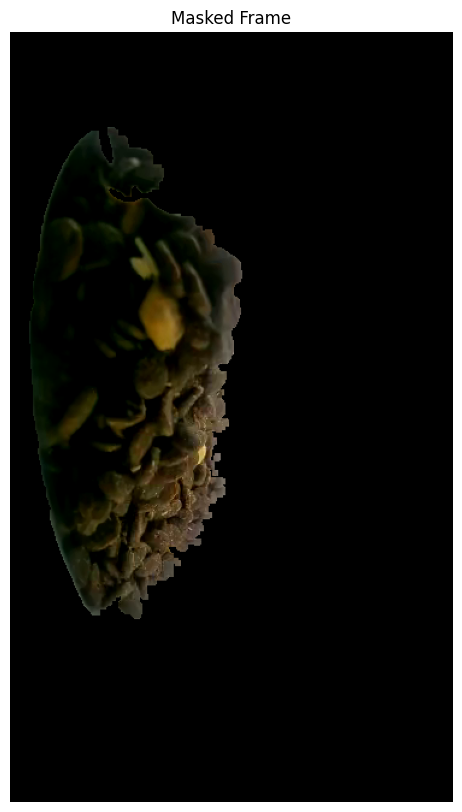

ret: 45834394.05200164
label: 4 (235520, 1)
center: [[255.66032  255.65791  255.65218 ]
 [ 18.232134  24.159649 255.      ]
 [ 40.67036   38.70038   16.12494 ]
 [ 98.870674  78.93232   50.219143]
 [254.99998    5.76381  254.99998 ]]
colors: [(255, 255, 255), (18, 24, 255), (40, 38, 16), (98, 78, 50), (254, 5, 254)]


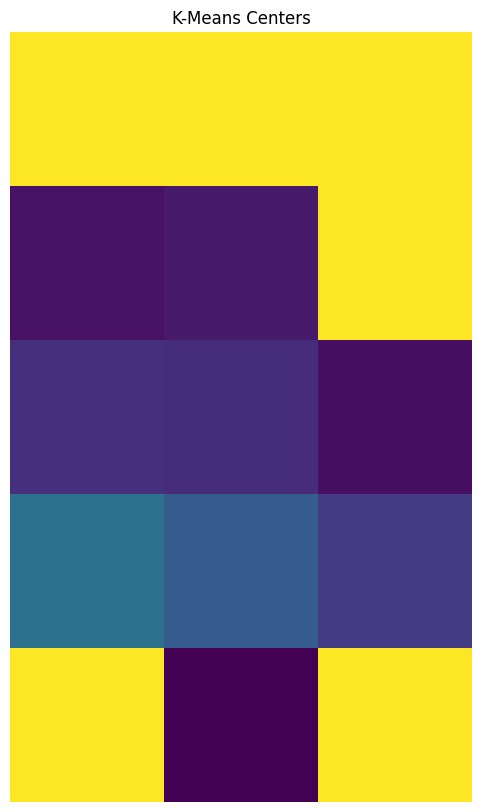

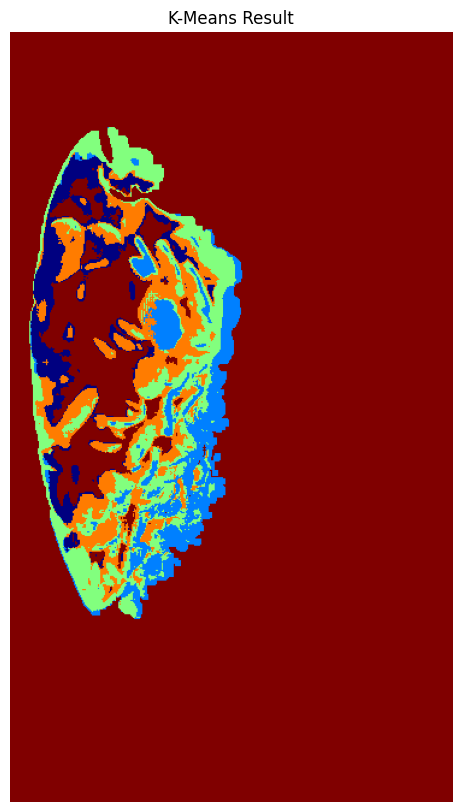

In [56]:
def diff_image(f1, f2):

    frame1 = cv2.cvtColor(f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(f2.copy(), cv2.COLOR_BGR2GRAY)
    
    frame3 = cv2.absdiff(frame1, frame2)

    _, thresh = cv2.threshold(frame3, 60, 255, cv2.THRESH_BINARY)

    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找到最大连通域
    max_contour = max(contours, key=cv2.contourArea)

    # 将最大连通域转换程mask
    mask = np.zeros(frame1.shape, np.uint8)
    cv2.drawContours(mask, [max_contour], 0, 255, -1)

    # 显示原始帧和带有轮廓的帧
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.title('First Frame')
    plt.imshow(f1)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(f2)
    plt.axis('off')
    plt.title('Second Frame')
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Frame with Contours')
    plt.show()


    # 使用mask将第二帧抠出来
    masked_frame = cv2.bitwise_and(f2, f2, mask=mask)
    # 显示抠出来的帧
    plt.figure(figsize=(10, 10))
    plt.imshow(masked_frame)
    plt.axis('off')
    plt.title('Masked Frame')
    plt.show()


    # 使用kmeans算法聚类, 忽略0的像素值
    masked_frame[masked_frame == 0] = 255

    Z = masked_frame.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 5
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # 解释kmeans的输出
    print('ret:', ret)
    print('label:', np.max(label), label.shape)
    print('center:', center)

    # 打印center的颜色
    colors = []
    for i in range(K):
        colors.append((int(center[i][0]), int(center[i][1]), int(center[i][2])))
    print('colors:', colors)
    # 显示聚类中心
    plt.figure(figsize=(10, 10))
    plt.imshow(center)
    plt.axis('off')
    plt.title('K-Means Centers')
    plt.show()
    # 显示每个像素的聚类结果
    
    result = label.reshape((masked_frame.shape[:2]))
    # colormap
    result = result.astype(np.float32)
    result = result / np.max(result) * 255
    result = cv2.applyColorMap(result.astype(np.uint8), cv2.COLORMAP_JET)
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.title('K-Means Result')
    plt.show()



diff_image(frame1, frame2)

In [15]:
mask = cv2.imread("mask_red_1715675377828.jpg")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

In [16]:
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i,j,0] >= 240 and mask[i,j,1] <= 10 and mask[i,j,2] <= 10:
            mask[i,j,0] = 255
            mask[i,j,1] = 255
            mask[i,j,2] = 255
            continue
        else:
            mask[i,j,0] = 0
            mask[i,j,1] = 0
            mask[i,j,2] = 0

In [17]:
image1 = frame2
ori_image_with_mask = cv2.bitwise_and(image1, image1, mask=mask[:,:,0])

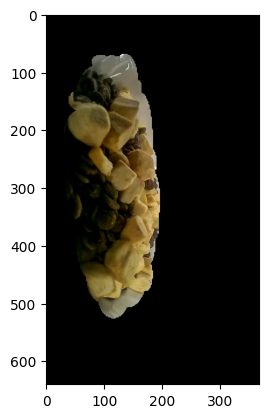

In [18]:
plt.imshow(ori_image_with_mask)

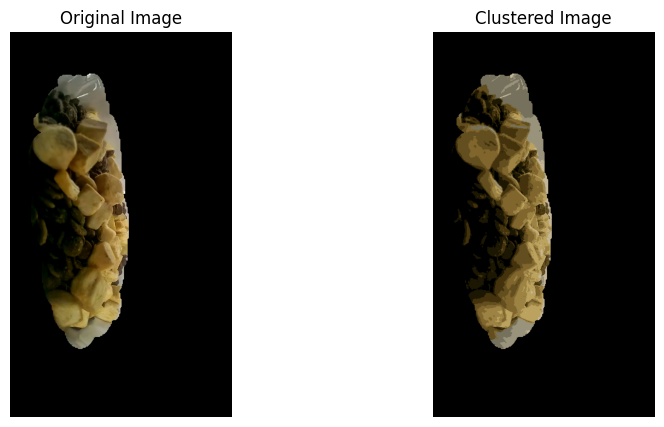

In [24]:
# use kmeans to cluster the data
# use opencv2 kmeans function to cluster the data
import cv2
import numpy as np

# load the data
data = ori_image_with_mask
image = ori_image_with_mask
# 重塑图像为二维数组，每行代表一个像素点的RGB值
pixel_values = data.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# 定义K-Means的参数
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 10  # 聚类的数量
attempts = 10  # 尝试次数

# 执行K-Means聚类
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

# 将中心点转换为uint8
centers = np.uint8(centers)

# 将每个像素点替换为中心点的值
clustered_image = centers[labels.flatten()]

# 重塑为原始图像的形状
clustered_image = clustered_image.reshape(image.shape)

# 显示原始图像和聚类后的图像
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(ori_image_with_mask)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Clustered Image')
plt.imshow(clustered_image)
plt.axis('off')

plt.show()